<h1 align="center">MSIN0114: Business Analytics Consulting Project</h1>
<h2 align="center">S2R Analytics, pt. 4.1</h2>

# Table of Contents

* [Part 5](#part5): Regression
    * [5.0](#5_0): Data splitting
    * [5.1](#5_1): Models
    * [5.2](#5_2): Models comparison
<br />
<br />
* [Part 6](#part6): Classification
    * [6.0](#6_0): Data splitting
    * [6.1](#6_1): Models
    * [6.2](#6_2): Models comparison
<br />
<br />
* [Part 7](#part7): Fine-tuning
    * [7.1](#7_1): XGBoost grid search
    * [7.2](#7_2): Random forest classifier grid earch
<br />
<br />
* [Part 8](#part8): Ensemble learning
    * [8.1](#8_1): Voting classifier
    * [8.2](#8_2): Stacking
<br />
<br />
* [Part 9](#part9): Evaluation of the final model
    * [9.1](#9_1): Confusion matrix
    * [9.2](#9_2): ROC curve
    * [9.3](#9_3): Prediction-recall curve
    * [9.4](#9_4): Cost matrix
    * [9.5](#9_5): Feature importance

## Notebook Setup

In [217]:
#Essentials
import pandas as pd
from pandas import Series, DataFrame
from pandas.api.types import CategoricalDtype
pd.options.display.max_columns = None
import sqlite3
import pyodbc
import numpy as np; np.random.seed(1)

#Image creation and display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.ticker import FuncFormatter
from yellowbrick.model_selection import FeatureImportances

#Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 

from sklearn.decomposition import PCA

#Metrics of accuracy
from numpy import mean
from numpy import std
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from pycm import *
import imbalanced_ensemble as imbens
from imbalanced_ensemble.ensemble.base import sort_dict_by_key
from collections import Counter

# Fine-tuning and enseble learning
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV

#Other
import itertools as it
import io
import os
os.sys.path
import sys
import glob
import concurrent.futures
from __future__ import print_function
import binascii
import struct
from PIL import Image
import scipy
import scipy.misc
import scipy.cluster
import datetime, time
import functools, operator
from datetime import datetime
from numpy.random import seed
from numpy.random import randn
from numpy import percentile

In [218]:
df = pd.read_csv('csv-files/preprocessed_data.csv')

If two features are collinear it means that they should have a Pearson correlation coefficient far away from 0, and much closer to 1 or -1.

In [ ]:
#URL: https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-pandas-columns-in-python
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

calculate_vif_(df)

dropping 'Director_ID' at index: 14
dropping 'Avg_Rec' at index: 21
dropping 'Manager_ID' at index: 10
dropping 'Delivered_on_Time' at index: 18
dropping 'Office' at index: 1
dropping 'Avg_Profit' at index: 18
dropping 'Rec_Class' at index: 18
dropping 'Director_Team' at index: 12
dropping 'Total_Num_Stages' at index: 4
dropping 'Director_Empl_Months' at index: 12
dropping 'Profit_Class' at index: 15
Remaining variables:
Index(['Country', 'Sector', 'Project_Size_Sort_Order',
       'Project_Duration_Weeks', 'Is_Multi_Discipline_Project',
       'Is_First_Client_Project', 'Default_Rate_Group',
       'Perc_of_Stages_with_Fixed_Fee', 'Manager_Team', 'Manager_Is_Recent',
       'Manager_Empl_Months', 'Director_Is_Recent', 'Perc_of_Subcontractors',
       'Is_Front_Loaded', 'Total_Data_Issues'],
      dtype='object')


,Country,Sector,Project_Size_Sort_Order,Project_Duration_Weeks,Is_Multi_Discipline_Project,Is_First_Client_Project,Default_Rate_Group,Perc_of_Stages_with_Fixed_Fee,Manager_Team,Manager_Is_Recent,Manager_Empl_Months,Director_Is_Recent,Perc_of_Subcontractors,Is_Front_Loaded,Total_Data_Issues
0,0,6,4.0,4.0,0,1,1,0.80,7,0,125.0,0,0.0,1,2.0
1,0,0,1.0,238.0,0,1,1,0.00,4,0,317.0,0,0.0,0,2.0
2,0,0,1.0,0.0,0,1,1,0.00,4,0,317.0,0,0.0,0,0.0
3,0,1,3.0,121.0,0,1,1,0.25,4,0,317.0,0,0.0,0,1.0
4,0,0,7.0,2.0,0,1,1,0.00,4,0,419.0,0,0.0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9626,0,9,3.0,18.0,0,0,0,1.00,5,0,176.0,0,0.0,0,1.0
9627,0,0,1.0,1.0,0,0,0,0.67,15,0,11.0,0,0.0,0,1.0
9628,0,0,1.0,1.0,0,0,0,0.50,16,0,28.0,1,0.0,0,1.0
9629,0,3,1.0,3.0,0,0,0,1.00,9,0,168.0,0,0.0,0,0.0


## Part 5: <a class="anchor" id="part5"></a> Regression

### 5.0 <a class="anchor" id="5_0"></a> Data splitting

In [ ]:
# Choose dependent variables
Y = df[['Avg_Profit']]

# Drop the dependent variables from the feature data set
X = df[['Country', 'Sector', 'Project_Size_Sort_Order',
       'Project_Duration_Weeks', 'Is_Multi_Discipline_Project',
       'Is_First_Client_Project', 'Default_Rate_Group',
       'Perc_of_Stages_with_Fixed_Fee', 'Manager_Team', 'Manager_Is_Recent',
       'Manager_Empl_Months', 'Director_Is_Recent', 'Perc_of_Subcontractors',
       'Is_Front_Loaded', 'Total_Data_Issues']]

# Scale the explanatory variables
#X1 = pd.DataFrame(preprocessing.normalize(X))
#X1.columns = X.columns
#X = X1

# Split data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1)

print(f'No. of training data: {X_train.shape[0]}')
print(f'No. of training targets: {Y_train.shape[0]}')
print(f'No. of testing data: {X_test.shape[0]}')
print(f'No. of testing targets: {Y_test.shape[0]}')

No. of training data: 7704
No. of training targets: 7704
No. of testing data: 1927
No. of testing targets: 1927


### 5.1 <a class="anchor" id="5_1"></a> Models

#### 5.1.1 <a class="anchor" id="5_1_1"></a> Linear regression

In [ ]:
lr = LinearRegression()
lr.fit(X_train, Y_train.values.ravel())

# Train data set
y_pred_train_lr = lr.predict(X_train)
lr_mse_train = mean_squared_error(Y_train, y_pred_train_lr)
lr_rmse_train = np.sqrt(lr_mse_train)
lr_r2_train = metrics.r2_score(Y_train, y_pred_train_lr)
print('Linear Regression R2 on train set: ', round(lr_r2_train, 2))

# Test data set
y_pred_test_lr = lr.predict(X_test)
lr_mse_test = mean_squared_error(Y_test, y_pred_test_lr)
lr_rmse_test = np.sqrt(lr_mse_test)
lr_r2_test = metrics.r2_score(Y_test, y_pred_test_lr)
print('Linear Regression R2 on test set: ', round(lr_r2_test, 2))

Linear Regression R2 on train set:  0.04
Linear Regression R2 on test set:  0.03


#### 5.1.2 <a class="anchor" id="5_1_2"></a> Lasso regression

In [ ]:
lasso = Lasso(random_state = 1)
lasso.fit(X_train, Y_train.values.ravel())

# Train data set
y_pred_train_lasso = lasso.predict(X_train)
lasso_mse_train = mean_squared_error(Y_train, y_pred_train_lasso)
lasso_rmse_train = np.sqrt(lasso_mse_train)
lasso_R2_train = metrics.r2_score(Y_train, y_pred_train_lasso)
print('Lasso Regression R2 on train set: ', round(lasso_R2_train, 2))

# Test data set
y_pred_test_lasso = lasso.predict(X_test)
lasso_mse_test = mean_squared_error(Y_test, y_pred_test_lasso)
lasso_rmse_test = np.sqrt(lasso_mse_test)
lasso_R2_test = metrics.r2_score(Y_test, y_pred_test_lasso)
print('Lasso Regression R2 on test set: ', round(lasso_R2_test, 2))

Lasso Regression R2 on train set:  0.0
Lasso Regression R2 on test set:  -0.0


#### 5.1.3 <a class="anchor" id="5_1_3"></a> Decision tree regressor

In [ ]:
dtr = DecisionTreeRegressor(random_state = 1)
dtr.fit(X_train, Y_train.values.ravel())

# Train data set
y_pred_train_dtr = dtr.predict(X_train)
dtr_mse_train = mean_squared_error(Y_train, y_pred_train_dtr)
dtr_rmse_train = np.sqrt(dtr_mse_train)
dtr_r2_train = metrics.r2_score(Y_train, y_pred_train_dtr)
print('Decision Tree R2 on train set: ', round(dtr_r2_train, 2))

# Test data set
y_pred_test_dtr = dtr.predict(X_test)
dtr_mse_test = mean_squared_error(Y_test, y_pred_test_dtr)
dtr_rmse_test = np.sqrt(dtr_mse_test)
dtr_r2_test = metrics.r2_score(Y_test, y_pred_test_dtr)
print('Decision Tree R2 on test set: ', round(dtr_r2_test, 2))

Decision Tree R2 on train set:  0.98
Decision Tree R2 on test set:  -0.27


#### 5.1.4 <a class="anchor" id="5_1_4"></a> Random forest regressor

In [ ]:
rfr = RandomForestRegressor(random_state = 1)
rfr.fit(X_train, Y_train.values.ravel())

# Train data set
y_pred_train_rfr = rfr.predict(X_train)
rfr_mse_train = mean_squared_error(Y_train, y_pred_train_rfr)
rfr_rmse_train = np.sqrt(rfr_mse_train)
rfr_R2_train = metrics.r2_score(Y_train, y_pred_train_rfr)
print('Random Forest R2 on train set: ', round(rfr_R2_train, 2))

# Test data set
y_pred_test_rfr = rfr.predict(X_test)
rfr_mse_test = mean_squared_error(Y_test, y_pred_test_rfr)
rfr_rmse_test = np.sqrt(rfr_mse_test)
rfr_R2_test = metrics.r2_score(Y_test, y_pred_test_rfr)
print('Random Forest R2 on test set: ', round(rfr_R2_test, 2))

Random Forest R2 on train set:  0.89
Random Forest R2 on test set:  0.31


c:\Users\MarfaPopova\S2R Analytics\Development & Support Team - Power BI for Synergy - Advanced Analytics\DataFlowExtract\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


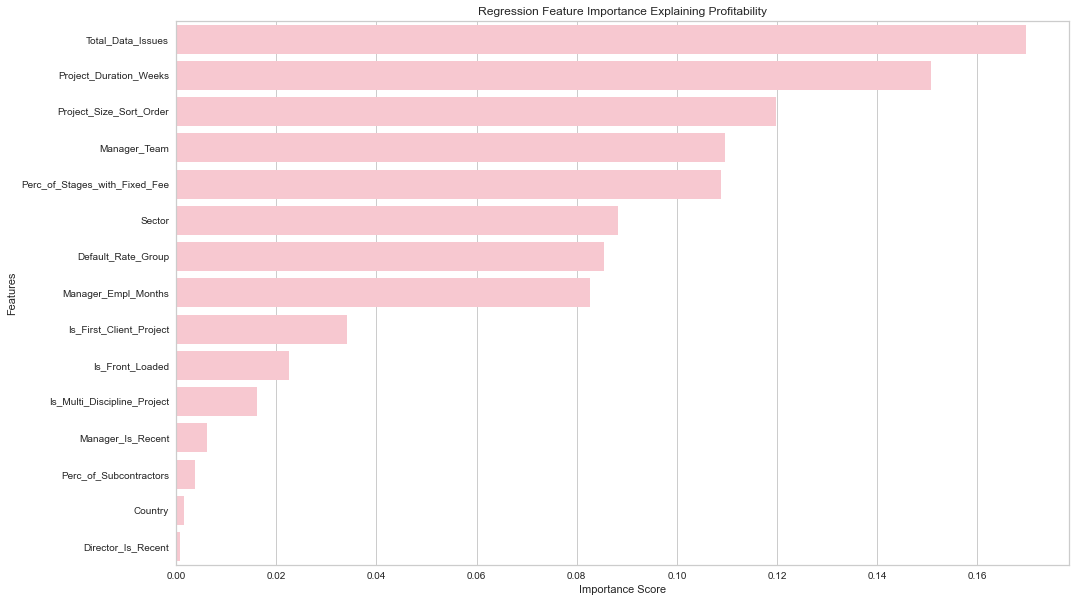

In [ ]:
# Create a new DataFrame for feature importance
rfr.feature_names = X.columns
final_feature_importance = pd.DataFrame({'Feature': rfr.feature_names,'Importance':rfr.feature_importances_})
final_feature_importance = final_feature_importance.sort_values(by = ['Importance'], ascending = False)

# Plotting the feature importance graph
fig, ax = plt.subplots(figsize = (16,10))
sns.barplot(final_feature_importance['Importance'], final_feature_importance['Feature'], color = 'pink')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.xticks(rotation = 'horizontal')
plt.title('Regression Feature Importance Explaining Profitability')
plt.savefig('figures/profit/Regression Feature Importance.png')

#### 5.1.5 <a class="anchor" id="5_1_5"></a> XGBoost regressor

In [ ]:
xgbr = XGBRegressor(random_state = 1)
xgbr.fit(X_train, Y_train.values.ravel())

# Train data set
y_pred_train_xgbr = xgbr.predict(X_train)
xgbr_mse_train = mean_squared_error(Y_train, y_pred_train_xgbr)
xgbr_rmse_train = np.sqrt(xgbr_mse_train)
xgbr_R2_train = metrics.r2_score(Y_train, y_pred_train_xgbr)
print('XGBoost R2 on train set: ', round(xgbr_R2_train, 2))

# Test data set
y_pred_test_xgbr = xgbr.predict(X_test)
xgbr_mse_test = mean_squared_error(Y_test, y_pred_test_xgbr)
xgbr_rmse_test = np.sqrt(xgbr_mse_test)
xgbr_R2_test = metrics.r2_score(Y_test, y_pred_test_xgbr)
print('XGBoost R2 on test set: ', round(xgbr_R2_test, 2))

XGBoost R2 on train set:  0.76
XGBoost R2 on test set:  0.31


### 5.2  <a class="anchor" id="5_2"></a> Models comparison

The highest R2 score is 0.26 by  XGBoost regressor, making regression models very unreliable in this case.

* Conclusion: Regression does not work for this dataset.
* Reason: The results of test dataset are way too diferent from nearly perfect training results, e.g. 0.74 versus 0.26 for XGBoost.
* Cause: The continuous uints of dependent varuable 'Avg_Rec' are very close to wach other, making it difficult for the algorithm to see a pattern between such similar distances between each point. - **NOT TRUE, IT SHOULD WORK**
* Next: Classification should work better.

## Part 6: <a class="anchor" id="part6"></a> Classification

### 6.0 <a class="anchor" id="6_0"></a> Data splitting

In [219]:
# Choose dependent variables
Y = df[['Profit_Class']]

# Drop the dependent variables from the feature data set
X = df[['Country', 'Sector', 'Project_Size_Sort_Order',
       'Project_Duration_Weeks', 'Is_Multi_Discipline_Project',
       'Is_First_Client_Project', 'Default_Rate_Group',
       'Perc_of_Stages_with_Fixed_Fee', 'Manager_Team', 'Manager_Is_Recent',
       'Manager_Empl_Months', 'Director_Is_Recent', 'Perc_of_Subcontractors',
       'Is_Front_Loaded', 'Total_Data_Issues']]

# Scale the explanatory variables
#X1 = pd.DataFrame(preprocessing.normalize(X))
#X1.columns = X.columns
#X = X1

# Split data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1, stratify = Y)

print(f'No. of training data: {X_train.shape[0]}')
print(f'No. of training targets: {Y_train.shape[0]}')
print(f'No. of testing data: {X_test.shape[0]}')
print(f'No. of testing targets: {Y_test.shape[0]}')

No. of training data: 7704
No. of training targets: 7704
No. of testing data: 1927
No. of testing targets: 1927


### 6.1 <a class="anchor" id="6_1"></a> Models

#### 6.1.1  <a class="anchor" id="6_1_1"></a> Logistic regression

In [225]:
# Create a logistic regression model
log = LogisticRegression(random_state = 1, max_iter = 30000)

# Train the model using train set
log.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
log_y_pred=log.predict(X_test)

# Accuracy measures
print('Accuracy score of LOG: ' + str(round(metrics.accuracy_score(Y_test, np.round(log_y_pred)), 3)*100)+'%')
print('Precision score of LOG: ' + str(round(metrics.precision_score(Y_test, np.round(log_y_pred), average='weighted', zero_division=0), 3)*100)+'%')
print('Recall score of LOG: ' + str(round(metrics.recall_score(Y_test, np.round(log_y_pred), average='weighted', zero_division=0), 3)*100)+'%')
print('F1 of LOG: ' + str(round(metrics.f1_score(Y_test, np.round(log_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of LOG: 58.5%
Precision score of LOG: 54.400000000000006%
Recall score of LOG: 58.5%
F1 of LOG: 55.400000000000006%


**Normalised independent variables**

In [ ]:
# Create a logistic regression model
log = LogisticRegression(random_state = 1, max_iter = 30000)

# Train the model using train set
log.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
log_y_pred=log.predict(X_test)

# Accuracy measures
print('Accuracy score of LOG: ' + str(round(metrics.accuracy_score(Y_test, np.round(log_y_pred)), 3)*100)+'%')
print('Precision score of LOG: ' + str(round(metrics.precision_score(Y_test, np.round(log_y_pred), average='weighted', zero_division=0), 3)*100)+'%')
print('Recall score of LOG: ' + str(round(metrics.recall_score(Y_test, np.round(log_y_pred), average='weighted', zero_division=0), 3)*100)+'%')
print('F1 of LOG: ' + str(round(metrics.f1_score(Y_test, np.round(log_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of LOG: 54.50000000000001%
Precision score of LOG: 51.6%
Recall score of LOG: 54.50000000000001%
F1 of LOG: 48.5%


#### 6.1.2  <a class="anchor" id="6_1_2"></a> Ridge regression classifier

In [220]:
# Create a ridge regression classifier model
rdg = RidgeClassifier(alpha=1.0, random_state = 1, max_iter = 30000)

# Train the model using train set
rdg.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
rdg_y_pred=rdg.predict(X_test)

# Accuracy measures
print('Accuracy score of RDG: ' + str(round(metrics.accuracy_score(Y_test, np.round(rdg_y_pred)), 3)*100)+'%')
print('Precision score of RDG: ' + str(round(metrics.precision_score(Y_test, np.round(rdg_y_pred), average='weighted', zero_division=0), 3)*100)+'%')
print('Recall score of RDG: ' + str(round(metrics.recall_score(Y_test, np.round(rdg_y_pred), average='weighted', zero_division=0), 3)*100)+'%')
print('F1 of RDG: ' + str(round(metrics.f1_score(Y_test, np.round(rdg_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of RDG: 57.3%
Precision score of RDG: 53.2%
Recall score of RDG: 57.3%
F1 of RDG: 54.0%


**Normalised independent variables**

In [ ]:
# Create a ridge regression classifier model
rdg = RidgeClassifier(alpha=1.0, random_state = 1, max_iter = 30000)

# Train the model using train set
rdg.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
rdg_y_pred=rdg.predict(X_test)

# Accuracy measures
print('Accuracy score of RDG: ' + str(round(metrics.accuracy_score(Y_test, np.round(rdg_y_pred)), 3)*100)+'%')
print('Precision score of RDG: ' + str(round(metrics.precision_score(Y_test, np.round(rdg_y_pred), average='weighted', zero_division=0), 3)*100)+'%')
print('Recall score of RDG: ' + str(round(metrics.recall_score(Y_test, np.round(rdg_y_pred), average='weighted', zero_division=0), 3)*100)+'%')
print('F1 of RDG: ' + str(round(metrics.f1_score(Y_test, np.round(rdg_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of RDG: 55.1%
Precision score of RDG: 52.400000000000006%
Recall score of RDG: 55.1%
F1 of RDG: 49.0%


#### 6.1.3 <a class="anchor" id="6_1_3"></a> K-Neighbours classifier

In [ ]:
# Create a k-Neighbours classifier model with 3 neighbours
np.random.seed(1)
knn_3 = KNeighborsClassifier(n_neighbors = 3)

# Train the model using train set
knn_3.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
knn_3_y_pred = knn_3.predict(X_test)

# Accuracy measures
print('Accuracy score of KNN-3: ' + str(round(metrics.accuracy_score(Y_test, np.round(knn_3_y_pred)), 3)*100)+'%')
print('Precision score of KNN-3: ' + str(round(metrics.precision_score(Y_test, np.round(knn_3_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of KNN-3 ' + str(round(metrics.recall_score(Y_test, np.round(knn_3_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of KNN-3: ' + str(round(metrics.f1_score(Y_test, np.round(knn_3_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of KNN-3: 55.50000000000001%
Precision score of KNN-3: 56.10000000000001%
Recall score of KNN-3 55.50000000000001%
F1 of KNN-3: 55.7%


In [221]:
# Create a k-Neighbours classifier model with 7 neighbours
np.random.seed(1)
knn_7 = KNeighborsClassifier(n_neighbors=7)

# Train the model using train set
knn_7.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
knn_7_y_pred = knn_7.predict(X_test)

# Accuracy measures
print('Accuracy score of KNN-7: ' + str(round(metrics.accuracy_score(Y_test, np.round(knn_7_y_pred)), 3)*100)+'%')
print('Precision score of KNN-7: ' + str(round(metrics.precision_score(Y_test, np.round(knn_7_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of KNN-7 ' + str(round(metrics.recall_score(Y_test, np.round(knn_7_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of KNN-7: ' + str(round(metrics.f1_score(Y_test, np.round(knn_7_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of KNN-7: 56.599999999999994%
Precision score of KNN-7: 56.39999999999999%
Recall score of KNN-7 56.599999999999994%
F1 of KNN-7: 56.10000000000001%


**Normalised independent variables**

In [ ]:
# Create a k-Neighbours classifier model with 7 neighbours
np.random.seed(1)
knn_7 = KNeighborsClassifier(n_neighbors=7)

# Train the model using train set
knn_7.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
knn_7_y_pred = knn_7.predict(X_test)

# Accuracy measures
print('Accuracy score of KNN-7: ' + str(round(metrics.accuracy_score(Y_test, np.round(knn_7_y_pred)), 3)*100)+'%')
print('Precision score of KNN-7: ' + str(round(metrics.precision_score(Y_test, np.round(knn_7_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of KNN-7 ' + str(round(metrics.recall_score(Y_test, np.round(knn_7_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of KNN-7: ' + str(round(metrics.f1_score(Y_test, np.round(knn_7_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of KNN-7: 58.199999999999996%
Precision score of KNN-7: 57.9%
Recall score of KNN-7 58.199999999999996%
F1 of KNN-7: 57.699999999999996%


#### 6.1.4  <a class="anchor" id="6_1_4"></a> Decision tree classifier

In [222]:
# Create a decision tree classifier model
dtc = DecisionTreeClassifier(random_state = 1)

# Train the model using train set
dtc = dtc.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
dtc_y_pred = dtc.predict(X_test)

# Accuracy measures
print('Accuracy score of DTC: ' + str(round(metrics.accuracy_score(Y_test, np.round(dtc_y_pred)), 3)*100)+'%')
print('Precision score of DTC: ' + str(round(metrics.precision_score(Y_test, np.round(dtc_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of DTC: ' + str(round(metrics.recall_score(Y_test, np.round(dtc_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of DTC: ' + str(round(metrics.f1_score(Y_test, np.round(dtc_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of DTC: 59.9%
Precision score of DTC: 60.199999999999996%
Recall score of DTC: 59.9%
F1 of DTC: 60.0%


**Normalised independent variables**

In [ ]:
# Create a decision tree classifier model
dtc = DecisionTreeClassifier(random_state = 1)

# Train the model using train set
dtc = dtc.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
dtc_y_pred = dtc.predict(X_test)

# Accuracy measures
print('Accuracy score of DTC: ' + str(round(metrics.accuracy_score(Y_test, np.round(dtc_y_pred)), 3)*100)+'%')
print('Precision score of DTC: ' + str(round(metrics.precision_score(Y_test, np.round(dtc_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of DTC: ' + str(round(metrics.recall_score(Y_test, np.round(dtc_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of DTC: ' + str(round(metrics.f1_score(Y_test, np.round(dtc_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of DTC: 59.3%
Precision score of DTC: 59.5%
Recall score of DTC: 59.3%
F1 of DTC: 59.3%


#### 6.1.5  <a class="anchor" id="6_1_5"></a> Random forest classifier

In [223]:
# Create a random forest classifier model
rfc = RandomForestClassifier(random_state = 1)

# Train the model using train set
rfc.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
rfc_y_pred=rfc.predict(X_test)

# Accuracy measures
print('Accuracy score of RFC: ' + str(round(metrics.accuracy_score(Y_test, np.round(rfc_y_pred)), 3)*100)+'%')
print('Precision score of RFC: ' + str(round(metrics.precision_score(Y_test, np.round(rfc_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of RFC: ' + str(round(metrics.recall_score(Y_test, np.round(rfc_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of RFC: ' + str(round(metrics.f1_score(Y_test, np.round(rfc_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of RFC: 66.0%
Precision score of RFC: 66.0%
Recall score of RFC: 66.0%
F1 of RFC: 65.8%


**Normalised independent variables**

In [ ]:
# Create a random forest classifier model
rfc = RandomForestClassifier(random_state = 1)

# Train the model using train set
rfc.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
rfc_y_pred=rfc.predict(X_test)

# Accuracy measures
print('Accuracy score of RFC: ' + str(round(metrics.accuracy_score(Y_test, np.round(rfc_y_pred)), 3)*100)+'%')
print('Precision score of RFC: ' + str(round(metrics.precision_score(Y_test, np.round(rfc_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of RFC: ' + str(round(metrics.recall_score(Y_test, np.round(rfc_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of RFC: ' + str(round(metrics.f1_score(Y_test, np.round(rfc_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of RFC: 65.2%
Precision score of RFC: 65.3%
Recall score of RFC: 65.2%
F1 of RFC: 64.9%


#### 6.1.6  <a class="anchor" id="6_1_6"></a> Gaussian classifier

In [224]:
# Create a Gaussian classifier model
xgbc = XGBClassifier(n_estimators=100, learning_rate=0.05, booster='gbtree', random_state = 1, eval_metric='mlogloss', objective='binary:logistic', use_label_encoder=False, num_class=3)

# Train the model using train set
xgbc.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
xgbc_y_pred=xgbc.predict(X_test)

# Accuracy measures
print('Accuracy score of XGBC: ' + str(round(metrics.accuracy_score(Y_test, np.round(xgbc_y_pred)), 3)*100)+'%')
print('Precision score of XGBC: ' + str(round(metrics.precision_score(Y_test, np.round(xgbc_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of XGBC: ' + str(round(metrics.recall_score(Y_test, np.round(xgbc_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of XGBC: ' + str(round(metrics.f1_score(Y_test, np.round(xgbc_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of XGBC: 67.4%
Precision score of XGBC: 67.7%
Recall score of XGBC: 67.4%
F1 of XGBC: 67.2%


**Normalised independent variables**

In [ ]:
# Create a Gaussian classifier model
xgbc = XGBClassifier(n_estimators=100, learning_rate=0.05, booster='gbtree', random_state = 1, eval_metric='mlogloss', use_label_encoder=False)

# Train the model using train set
xgbc.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
xgbc_y_pred=xgbc.predict(X_test)

# Accuracy measures
print('Accuracy score of XGBC: ' + str(round(metrics.accuracy_score(Y_test, np.round(xgbc_y_pred)), 3)*100)+'%')
print('Precision score of XGBC: ' + str(round(metrics.precision_score(Y_test, np.round(xgbc_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of XGBC: ' + str(round(metrics.recall_score(Y_test, np.round(xgbc_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of XGBC: ' + str(round(metrics.f1_score(Y_test, np.round(xgbc_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of XGBC: 66.0%
Precision score of XGBC: 66.2%
Recall score of XGBC: 66.0%
F1 of XGBC: 65.7%


**Rerun first Gaussian classifier with non-normalised variables before running next cell!**

c:\Users\MarfaPopova\S2R Analytics\Development & Support Team - Power BI for Synergy - Advanced Analytics\DataFlowExtract\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


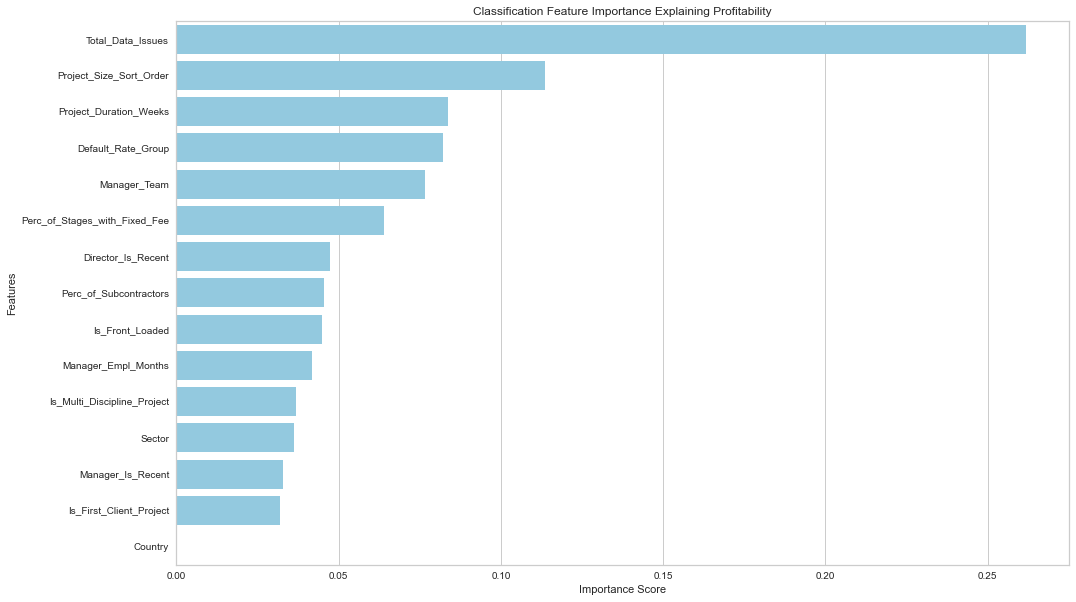

In [ ]:
# Create a new DataFrame for feature importance
xgbc.feature_names = X.columns
final_feature_importance = pd.DataFrame({'Feature': xgbc.feature_names,'Importance':xgbc.feature_importances_})
final_feature_importance = final_feature_importance.sort_values(by = ['Importance'], ascending = False)

# Plotting the feature importance graph
fig, ax = plt.subplots(figsize = (16,10))
sns.barplot(final_feature_importance['Importance'], final_feature_importance['Feature'], color = 'skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.xticks(rotation = 'horizontal')
plt.title('Classification Feature Importance Explaining Profitability')
plt.savefig('figures/profit/Classification Feature Importance.png')

#### 6.1.7  <a class="anchor" id="6_1_7"></a> Naive Bayes

In [226]:
# Create a Naive Bayes model
gnb = GaussianNB()

# Train the model using train set
gnb.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
gnb_y_pred = gnb.predict(X_test)

# Accuracy measures
print('Accuracy score of GNB: ' + str(round(metrics.accuracy_score(Y_test, np.round(gnb_y_pred)), 3)*100)+'%')
print('Precision score of GNB: ' + str(round(metrics.precision_score(Y_test, np.round(gnb_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of GNB: ' + str(round(metrics.recall_score(Y_test, np.round(gnb_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of GNB: ' + str(round(metrics.f1_score(Y_test, np.round(gnb_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of GNB: 51.300000000000004%
Precision score of GNB: 50.5%
Recall score of GNB: 51.300000000000004%
F1 of GNB: 46.2%


**Normalised independent variables**

In [ ]:
# Create a Naive Bayes model
gnb = GaussianNB()

# Train the model using train set
gnb.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
gnb_y_pred = gnb.predict(X_test)

# Accuracy measures
print('Accuracy score of GNB: ' + str(round(metrics.accuracy_score(Y_test, np.round(gnb_y_pred)), 3)*100)+'%')
print('Precision score of GNB: ' + str(round(metrics.precision_score(Y_test, np.round(gnb_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of GNB: ' + str(round(metrics.recall_score(Y_test, np.round(gnb_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of GNB: ' + str(round(metrics.f1_score(Y_test, np.round(gnb_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of GNB: 52.800000000000004%
Precision score of GNB: 49.3%
Recall score of GNB: 52.800000000000004%
F1 of GNB: 48.3%


#### 6.1.8  <a class="anchor" id="6_1_8"></a> Linear discriminant analysis

In [227]:
# Create a linear discriminant analysis model
lda = LinearDiscriminantAnalysis(n_components = 2)

# Train the model using train set
lda.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
lda_y_pred = lda.predict(X_test)

# Accuracy measures
print('Accuracy score of LDA: ' + str(round(metrics.accuracy_score(Y_test, np.round(lda_y_pred)), 3)*100)+'%')
print('Precision score of LDA: ' + str(round(metrics.precision_score(Y_test, np.round(lda_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of LDA: ' + str(round(metrics.recall_score(Y_test, np.round(lda_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of LDA: ' + str(round(metrics.f1_score(Y_test, np.round(lda_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of LDA: 57.199999999999996%
Precision score of LDA: 60.4%
Recall score of LDA: 57.199999999999996%
F1 of LDA: 54.0%


**Normalised independent variables**

In [ ]:
# Create a linear discriminant analysis model
lda = LinearDiscriminantAnalysis(n_components = 2)

# Train the model using train set
lda.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
lda_y_pred = lda.predict(X_test)

# Accuracy measures
print('Accuracy score of LDA: ' + str(round(metrics.accuracy_score(Y_test, np.round(lda_y_pred)), 3)*100)+'%')
print('Precision score of LDA: ' + str(round(metrics.precision_score(Y_test, np.round(lda_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of LDA: ' + str(round(metrics.recall_score(Y_test, np.round(lda_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of LDA: ' + str(round(metrics.f1_score(Y_test, np.round(lda_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of LDA: 56.00000000000001%
Precision score of LDA: 55.800000000000004%
Recall score of LDA: 56.00000000000001%
F1 of LDA: 50.6%


#### 6.1.9  <a class="anchor" id="6_1_9"></a> Quadratic discriminant analysis

In [228]:
# Create a quadratic discriminant analysis model
qda = QuadraticDiscriminantAnalysis()

# Train the model using train set
qda.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
qda_y_pred = qda.predict(X_test)

# Accuracy measures
print('Accuracy score of QDA: ' + str(round(metrics.accuracy_score(Y_test, np.round(qda_y_pred)), 3)*100)+'%')
print('Precision score of QDA: ' + str(round(metrics.precision_score(Y_test, np.round(qda_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of QDA: ' + str(round(metrics.recall_score(Y_test, np.round(qda_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of QDA: ' + str(round(metrics.f1_score(Y_test, np.round(qda_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of QDA: 54.800000000000004%
Precision score of QDA: 55.400000000000006%
Recall score of QDA: 54.800000000000004%
F1 of QDA: 51.5%


**Normalised independent variables**

In [ ]:
# Create a quadratic discriminant analysis model
qda = QuadraticDiscriminantAnalysis()

# Train the model using train set
qda.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
qda_y_pred = qda.predict(X_test)

# Accuracy measures
print('Accuracy score of QDA: ' + str(round(metrics.accuracy_score(Y_test, np.round(qda_y_pred)), 3)*100)+'%')
print('Precision score of QDA: ' + str(round(metrics.precision_score(Y_test, np.round(qda_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of QDA: ' + str(round(metrics.recall_score(Y_test, np.round(qda_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of QDA: ' + str(round(metrics.f1_score(Y_test, np.round(qda_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of QDA: 52.400000000000006%
Precision score of QDA: 49.3%
Recall score of QDA: 52.400000000000006%
F1 of QDA: 47.8%


#### 6.1.10  <a class="anchor" id="6_1_10"></a> Mixture discriminant analysis

#### 6.1.11  <a class="anchor" id="6_1_11"></a> Regularized discriminant analysis

#### 6.1.12  <a class="anchor" id="6_1_12"></a> Flexible discriminant analysis

#### 6.1.13  <a class="anchor" id="6_1_13"></a> Neural network

#### 6.1.14  <a class="anchor" id="6_1_14"></a> Support vector machines

### 6.2  <a class="anchor" id="6_2"></a> Models comparison

Gaussian classifier has resulted in the best scored among all metrics, varying between 69.1 and 70.0%. This model will proceed to fine-tuning and will be included in ensemble learning with second best model, random forest classifier.

* Conclusion: Regression does not work for this dataset.
* Reason: The results of test dataset are way too diferent from perfect training results of 0.9 and 1.
* Cause: The continuous uints of dependent varuable 'Avg_Rec' are very close to wach other, making it difficult for the algorithm to see a pattern between such similar distances between each point.
* Next: Classification should work better.

In [ ]:
# Cross-validation

xgbc_cv = cross_val_score(xgbc, X_train, Y_train.values.ravel(), cv=6, scoring='accuracy')
print('XGB accuracy score is ' + str(round(xgbc_cv[1],3)*100) + '%')

rfc_cv = cross_val_score(rfc, X_train, Y_train.values.ravel(), cv=6, scoring='accuracy')
print('RFC accuracy score is ' + str(round(rfc_cv[1],3)*100) + '%')

dtc_cv = cross_val_score(dtc, X_train, Y_train.values.ravel(), cv=6, scoring='accuracy')
print('DTC accuracy score is ' + str(round(dtc_cv[1],3)*100) + '%')

log_cv = cross_val_score(log, X_train, Y_train.values.ravel(), cv=6, scoring='accuracy')
print('LOG accuracy score is ' + str(round(log_cv[1],3)*100) + '%')

knn_cv = cross_val_score(knn_7, X_train, Y_train.values.ravel(), cv=6, scoring='accuracy')
print('KNN accuracy score is ' + str(round(knn_cv[1],3)*100) + '%')

lda_cv = cross_val_score(lda, X_train, Y_train.values.ravel(), cv=6, scoring='accuracy')
print('LDA accuracy score is ' + str(round(lda_cv[1],3)*100) + '%')

XGB accuracy score is 67.60000000000001%
RFC accuracy score is 65.7%
DTC accuracy score is 56.49999999999999%
LOG accuracy score is 57.099999999999994%
KNN accuracy score is 55.900000000000006%
LDA accuracy score is 56.39999999999999%


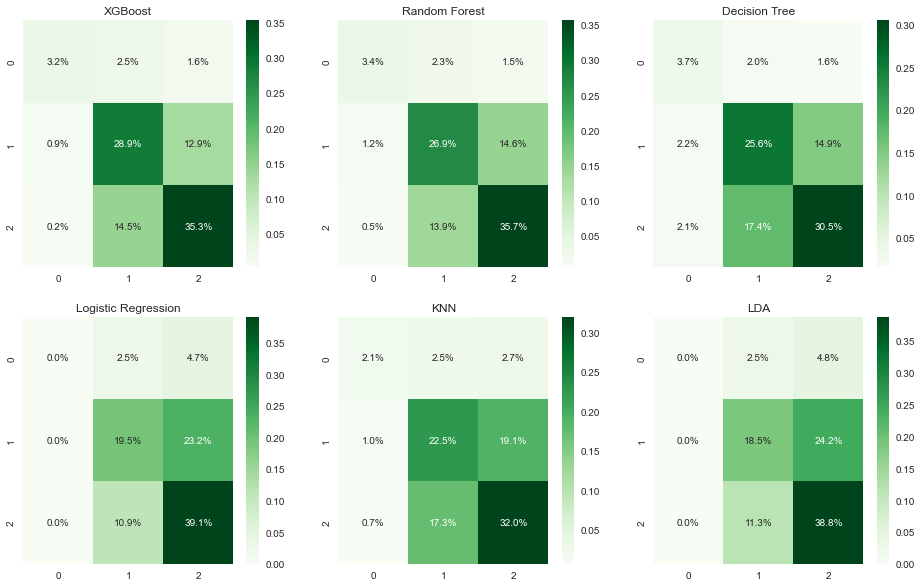

In [ ]:
# Setting figure to compare the confusion matrix of each model based on heatmaps
fig, ax = plt.subplots(figsize = (16,10))
ax.set_title('Top 6 confusion matrices', size = 17, pad = 10)

# XGBoost Classifier
plt.subplot(2,3,1)
sns.heatmap(confusion_matrix(Y_test, np.round(xgbc_y_pred))/np.sum(confusion_matrix(Y_test, np.round(xgbc_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('XGBoost')

# Random Forest Classifier
plt.subplot(2,3,2)
sns.heatmap(confusion_matrix(Y_test, np.round(rfc_y_pred))/np.sum(confusion_matrix(Y_test, np.round(rfc_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('Random Forest')

# Decision Tree Classifier
plt.subplot(2,3,3)
sns.heatmap(confusion_matrix(Y_test, np.round(dtc_y_pred))/np.sum(confusion_matrix(Y_test, np.round(dtc_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('Decision Tree')

# Logistic Regression
plt.subplot(2,3,4)
sns.heatmap(confusion_matrix(Y_test, np.round(log_y_pred))/np.sum(confusion_matrix(Y_test, np.round(log_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('Logistic Regression')

# 7-Nested Neighbours
plt.subplot(2,3,5)
sns.heatmap(confusion_matrix(Y_test, np.round(knn_7_y_pred))/np.sum(confusion_matrix(Y_test, np.round(knn_7_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('KNN')

# Linear Discriminant Analysis
plt.subplot(2,3,6)
sns.heatmap(confusion_matrix(Y_test, np.round(lda_y_pred))/np.sum(confusion_matrix(Y_test, np.round(lda_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('LDA')

plt.savefig('figures/profit/Top 6 confusion matrices')

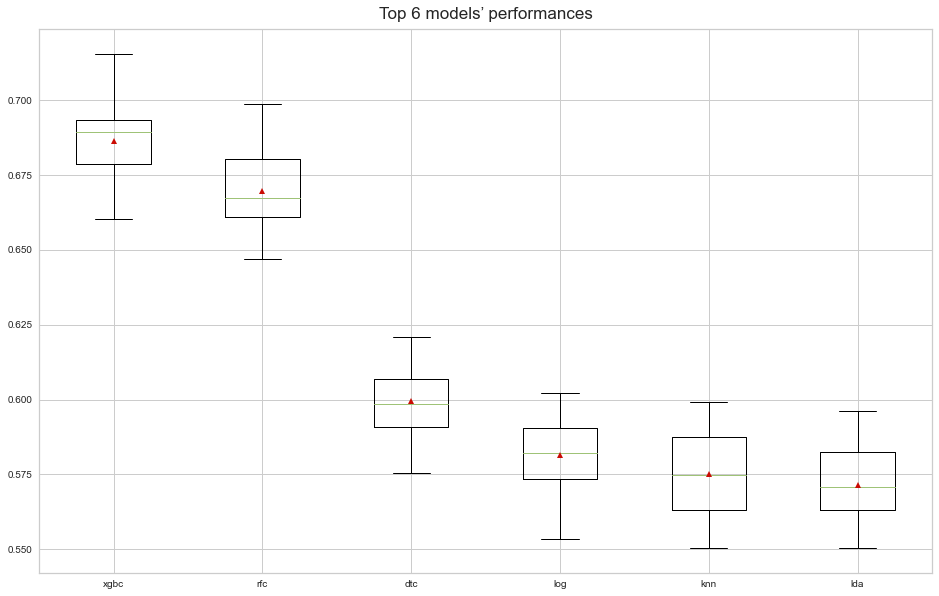

In [ ]:
#URL: https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

fig, ax = plt.subplots(figsize = (16,10))

# get a list of models to evaluate
def get_models():
	models = dict()
	models['xgbc'] = xgbc
	models['rfc'] = rfc
	models['dtc'] = dtc
	models['log'] = log
	models['knn'] = knn_7
	models['lda'] = lda
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, Y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, X, Y)
  results.append(scores)
  names.append(name)

# plot model performance for comparison
ax.set_title('Top 6 models’ performances', size = 17, pad = 10)
pyplot.boxplot(results, labels=names, showmeans=True)
fig.savefig('figures/profit/Top 6 models’ performances', dpi=fig.dpi)

Orange lines indicate accuracy mean, green triangles - mean accuracy per model.

## Part 7: <a class="anchor" id="part7"></a> Fine-tuning

### 7.1  <a class="anchor" id="7_1"></a> XGBoost grid search

In [ ]:
# Look at parameters used by our current XGBoost model
print('Parameters currently in use:\n')
pprint(xgbc.get_params())

Parameters currently in use:

{'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'mlogloss',
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.05,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_class': 3,
 'num_parallel_tree': 1,
 'objective': 'multi:softprob',
 'predictor': 'auto',
 'random_state': 1,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'use_label_encoder': False,
 'validate_parameters': 1,
 'verbosity': None}


In [ ]:
#URL: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

# Defining parameter range
xgbc_grid = {'learning_rate':[0.1],
    'n_estimators':[1000],
    'max_depth':[4,5,6],
    'min_child_weight':[6,8,10,12],
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'objective':['binary:logistic'],
    'nthread':[4],
    'scale_pos_weight':[1],
    'seed':[1],
    'metric':['multiclass'],
    'eval_metric':['mlogloss']}

pprint(xgbc_grid)

{'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
 'eval_metric': ['mlogloss'],
 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
 'learning_rate': [0.1],
 'max_depth': [4, 5, 6],
 'metric': ['multiclass'],
 'min_child_weight': [6, 8, 10, 12],
 'n_estimators': [1000],
 'nthread': [4],
 'objective': ['binary:logistic'],
 'scale_pos_weight': [1],
 'seed': [1],
 'subsample': [0.6, 0.7, 0.8, 0.9]}


In [ ]:
# Fitting the model for grid search
xgbc_tuned = GridSearchCV(XGBClassifier(), xgbc_grid, refit = True)
xgbc_tuned.fit(X_train, Y_train.values.ravel())

[13:51:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:51:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:51:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "sca

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...
                                     reg_lambda=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'eval_metric': ['mlogloss'],
                         'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'learning_rate': [0.1], 'max_depth': [4, 5, 6],
                         'metric': ['multiclass'],
                         'min_child_weight': [6, 8, 10, 12],
                         'n_estimators': [1000], 'nthread': [4],
                         'objective': ['binary:logistic'],
                         'scale_pos_weight': [1], 'seed': [1],
                         'subsample': [0.6, 0.7, 0.8, 0.9]})

In [ ]:
# Print best parameter after tuning
print(xgbc_tuned.best_params_)
 
# Print how our model looks after hyper-parameter tuning
print(xgbc_tuned.best_estimator_)

{'colsample_bytree': 0.6, 'eval_metric': 'mlogloss', 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'metric': 'multiclass', 'min_child_weight': 12, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'seed': 1, 'subsample': 0.9}
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0.2, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
              metric='multiclass', min_child_weight=12, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=4, nthread=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)


In [229]:
# Create a tuned XGBC model
xgbc_tuned = XGBClassifier(colsample_bytree=0.6, eval_metric='mlogloss',
gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=12, n_estimators=1000,
nthread=4, objective='binary:logistic', seed=1, subsample=0.9, num_class=3)

In [232]:
# Base model results
xgbc_base_y_pred = xgbc.predict(X_test)
xgbc_base_accuracy = round(metrics.accuracy_score(Y_test, np.round(xgbc_base_y_pred)), 3)*100
print('Accuracy of base XGBC is ' + str(xgbc_base_accuracy)+'%')

# Tuned model results
xgbc_tuned.fit(X_train, Y_train.values.ravel())
xgbc_tuned_y_pred = xgbc_tuned.predict(X_test)
xgbc_tuned_accuracy = round(metrics.accuracy_score(Y_test, np.round(xgbc_tuned_y_pred)), 3)*100
print('Accuracy of tuned XGBC is ' + str(xgbc_tuned_accuracy)+'%')

# Comparison
print('Improvement of {:0.1f}%'.format(100 * (xgbc_tuned_accuracy - xgbc_base_accuracy) / xgbc_base_accuracy))

Accuracy of base XGBC is 67.4%
Accuracy of tuned XGBC is 68.10000000000001%
Improvement of 1.0%


### 7.2  <a class="anchor" id="7_2"></a> Random forest classifier grid search

In [ ]:
# Look at parameters used by our current random forest
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [230]:
# URL: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto','sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
                     'max_features': max_features,
                     'max_depth': max_depth,
                     'min_samples_split': min_samples_split,
                      'min_samples_leaf': min_samples_leaf,
                      'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [231]:
rfc_tuned = RandomizedSearchCV(estimator = rfc,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 5,
                               verbose = 2,
                               random_state = 1,
                               n_jobs = -1)
                               
# Fit the random search model
rfc_tuned.fit(X_train, Y_train.values.ravel())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=1, verbose=2)

In [233]:
# Base model results
rfc_base_y_pred = rfc.predict(X_test)
rfc_base_accuracy = round(metrics.accuracy_score(Y_test, np.round(rfc_base_y_pred)), 3)*100
print('Accuracy of base RFC is ' + str(rfc_base_accuracy)+'%')

# Tuned model results
rfc_tuned = rfc_tuned.best_estimator_
rfc_tuned.fit(X_train, Y_train.values.ravel())
rfc_tuned_y_pred = rfc_tuned.predict(X_test)
rfc_tuned_accuracy = round(metrics.accuracy_score(Y_test, np.round(rfc_tuned_y_pred)), 3)*100
print('Accuracy of tuned RFC is ' + str(rfc_tuned_accuracy)+'%')

# Comparison
print('Improvement of {:0.1f}%'.format(100 * (rfc_tuned_accuracy - rfc_base_accuracy) / rfc_base_accuracy))

Accuracy of base RFC is 66.0%
Accuracy of tuned RFC is 68.7%
Improvement of 4.1%


## Part 8: <a class="anchor" id="part8"></a> Ensemble learning

### 8.1  <a class="anchor" id="8_1"></a> Voting classifier

In [234]:
soft_voting = VotingClassifier(
    estimators=[('xgbc_t', xgbc_tuned), ('rfc_t', rfc_tuned)],
    voting='soft')

soft_voting.fit(X_train, Y_train.values.ravel())
sv_y_pred = soft_voting.predict(X_test)
print(classification_report(Y_test, np.round(sv_y_pred)))

              precision    recall  f1-score   support

           0       0.72      0.49      0.58       140
           1       0.65      0.70      0.67       823
           2       0.72      0.71      0.72       964

    accuracy                           0.69      1927
   macro avg       0.70      0.63      0.66      1927
weighted avg       0.69      0.69      0.69      1927



In [ ]:
print('Accuracy score of soft voting classifier: ' + str(round(metrics.accuracy_score(Y_test, np.round(sv_y_pred)), 3)*100)+'%')
print('Precision score of soft voting classifier: ' + str(round(metrics.precision_score(Y_test, np.round(sv_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of soft voting classifier ' + str(round(metrics.recall_score(Y_test, np.round(sv_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of soft voting classifier: ' + str(round(metrics.f1_score(Y_test, np.round(sv_y_pred), average='weighted'), 3)*100)+'%')
sv_cv = cross_val_score(soft_voting, X_train, Y_train.values.ravel(), cv=5, scoring='accuracy')
print('Final accuracy score of soft voting classifier on validation dataset is ' + str(round(sv_cv[1],3)*100) + '%')

Accuracy score of soft voting classifier: 68.89999999999999%
Precision score of soft voting classifier: 69.19999999999999%
Recall score of soft voting classifier 68.89999999999999%
F1 of soft voting classifier: 68.8%
Final accuracy score of soft voting classifier on validation dataset is 68.7%


In [235]:
hard_voting = VotingClassifier(
    estimators=[('xgbc_t', xgbc_tuned), ('rfc_t', rfc_tuned)],
    voting='hard')

hard_voting.fit(X_train, Y_train.values.ravel())
hv_y_pred = hard_voting.predict(X_test)
print(classification_report(Y_test, np.round(hv_y_pred)))

              precision    recall  f1-score   support

           0       0.62      0.50      0.55       140
           1       0.63      0.75      0.69       823
           2       0.76      0.67      0.71       964

    accuracy                           0.69      1927
   macro avg       0.67      0.64      0.65      1927
weighted avg       0.70      0.69      0.69      1927



In [ ]:
print('Accuracy score of hard voting classifier: ' + str(round(metrics.accuracy_score(Y_test, np.round(hv_y_pred)), 3)*100)+'%')
print('Precision score of hard voting classifier: ' + str(round(metrics.precision_score(Y_test, np.round(hv_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of hard voting classifier ' + str(round(metrics.recall_score(Y_test, np.round(hv_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of hard voting classifier: ' + str(round(metrics.f1_score(Y_test, np.round(hv_y_pred), average='weighted'), 3)*100)+'%')
hv_cv = cross_val_score(hard_voting, X_train, Y_train.values.ravel(), cv=5, scoring='accuracy')
print('Final accuracy score of hard voting classifier on validation dataset is ' + str(round(hv_cv[1],3)*100) + '%')

Accuracy score of hard voting classifier: 68.89999999999999%
Precision score of hard voting classifier: 69.6%
Recall score of hard voting classifier 68.89999999999999%
F1 of hard voting classifier: 68.8%
Final accuracy score of hard voting classifier on validation dataset is 68.30000000000001%


### 8.2  <a class="anchor" id="8_2"></a> Stacking

#### 8.2.1  <a class="anchor" id="8_2_1"></a> Top 9 models

In [ ]:
# Get a stacking ensemble of models
def get_stacking():
	# Define the base models
	level9 = list()
	level9.append(('gnb', gnb))
	level9.append(('qda', qda))
	level9.append(('lda', lda))
	level9.append(('log', log))
	level9.append(('knn', knn_7))
	level9.append(('dtc', dtc))
	level9.append(('soft voting', soft_voting))
	level9.append(('rfc tuned', rfc_tuned))
	level9.append(('xgbc tuned', xgbc_tuned))

	# Define the stacking ensemble
	model = StackingClassifier(estimators=level9, final_estimator=xgbc_tuned, cv=5)
	return model

# Define the base models separately
level9 = list()
level9.append(('gnb', gnb))
level9.append(('qda', qda))
level9.append(('lda', lda))
level9.append(('log', log))
level9.append(('knn', knn_7))
level9.append(('dtc', dtc))
level9.append(('soft voting', soft_voting))
level9.append(('rfc tuned', rfc_tuned))
level9.append(('xgbc tuned', xgbc_tuned))
level9.append(('stacking', get_stacking()))

>GNB 0.527 (0.038)
>QDA 0.541 (0.034)
>LDA 0.571 (0.013)
>LOG 0.582 (0.012)
>KNN 0.575 (0.012)
>DTC 0.599 (0.012)
>SD 0.692 (0.011)
>RFC_T 0.685 (0.014)
>XGBC_T 0.690 (0.010)
>STACKING 0.653 (0.012)


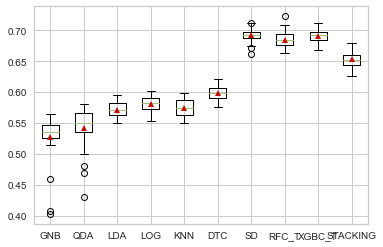

In [ ]:
#URL: https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

# Get a list of models to evaluate
def get_models():
	models = dict()
	models['GNB'] = gnb
	models['QDA'] = qda
	models['LDA'] = lda
	models['LOG'] = log
	models['KNN'] = knn_7
	models['DTC'] = dtc
	models['SD'] = soft_voting
	models['RFC_T'] = rfc_tuned
	models['XGBC_T'] = xgbc_tuned
	models['STACKING'] = get_stacking()
	return models

# Evaluate a given model using cross-validation
def evaluate_model(model, X, Y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# Get the models to evaluate
models = get_models()

# Evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, Y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
	
# Plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
# Define the model
xgbc_t_stack9 = StackingClassifier(estimators=level9, final_estimator=xgbc_tuned, cv=5)

# Fit the model on all available data
xgbc_t_stack9 = xgbc_t_stack9.fit(X, Y.values.ravel())

# Predict the response for test set
xgbc_t_stack9_y_pred = xgbc_t_stack9.predict(X_test)

In [ ]:
# Accuracy measures
print('Accuracy score with 9 models learnt on tuned XGBC: ' + str(round(metrics.accuracy_score(Y_test, np.round(xgbc_t_stack9_y_pred)), 3)*100)+'%')
print('Recall score  with 9 models learnt on tuned XGBC: ' + str(round(metrics.recall_score(Y_test, np.round(xgbc_t_stack9_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score  with 9 models learnt on tuned XGBC: ' + str(round(metrics.precision_score(Y_test, np.round(xgbc_t_stack9_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 9 models learnt on tuned XGBC: ' + str(round(metrics.f1_score(Y_test, np.round(xgbc_t_stack9_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of the final model: 73.8%
Recall score of the final model: 73.8%
Precision score of the final model: 74.3%
F1 of final the model: 73.7%


#### 8.2.2  <a class="anchor" id="8_2_2"></a> Top 8 models

In [ ]:
def get_stacking():
	# Define the base models
	level8 = list()
	level8.append(('qda', qda))
	level8.append(('lda', lda))
	level8.append(('log', log))
	level8.append(('knn', knn_7))
	level8.append(('dtc', dtc))
	level8.append(('soft voting', soft_voting))
	level8.append(('rfc tuned', rfc_tuned))
	level8.append(('xgbc tuned', xgbc_tuned))

	# Define the stacking ensemble learnt on tuned random forest classifier
	model = StackingClassifier(estimators=level8, final_estimator=rfc_tuned, cv=5)
	return model

In [ ]:
# Define the base models separately
level8 = list()
level8.append(('qda', qda))
level8.append(('lda', lda))
level8.append(('log', log))
level8.append(('knn', knn_7))
level8.append(('dtc', dtc))
level8.append(('soft voting', soft_voting))
level8.append(('rfc tuned', rfc_tuned))
level8.append(('xgbc tuned', xgbc_tuned))
level8.append(('stacking', get_stacking()))

In [ ]:
# Define the stacking ensemble learnt on tuned random forest classifier
rfc_t_stack8 = StackingClassifier(estimators=level8, final_estimator=rfc_tuned, cv=5)

# Fit the model on all available data
rfc_t_stack8 = rfc_t_stack8.fit(X, Y.values.ravel())

# Predict the response for test set
rfc_t_stack8_y_pred = rfc_t_stack8.predict(X_test)

[11:58:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:02:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:04:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "sca

c:\Users\MarfaPopova\S2R Analytics\Development & Support Team - Power BI for Synergy - Advanced Analytics\DataFlowExtract\venv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[13:16:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:20:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:23:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "sca

In [ ]:
# Accuracy measures
print('Accuracy score with 8 models learnt on tuned RFC: ' + str(round(metrics.accuracy_score(Y_test, np.round(rfc_t_stack8_y_pred)), 3)*100)+'%')
print('Recall score with 8 models learnt on tuned RFC: ' + str(round(metrics.recall_score(Y_test, np.round(rfc_t_stack8_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score with 8 models learnt on tuned RFC: ' + str(round(metrics.precision_score(Y_test, np.round(rfc_t_stack8_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 8 models learnt on tuned RFC: ' + str(round(metrics.f1_score(Y_test, np.round(rfc_t_stack8_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score with 8 models learnt on tuned RFC: 78.5%
Recall score with 8 models learnt on tuned RFC: 78.5%
Precision score with 8 models learnt on tuned RFC: 79.2%
F1 score with 8 models learnt on tuned RFC: 78.4%


In [ ]:
# Get a stacking ensemble of models
def get_stacking():
	# Define the base models
	level8 = list()
	level8.append(('qda', qda))
	level8.append(('lda', lda))
	level8.append(('log', log))
	level8.append(('knn', knn_7))
	level8.append(('dtc', dtc))
	level8.append(('soft voting', soft_voting))
	level8.append(('rfc tuned', rfc_tuned))
	level8.append(('xgbc tuned', xgbc_tuned))

	# Define the stacking ensemble learnt on tuned Gaussian classifier
	model = StackingClassifier(estimators=level8, final_estimator=xgbc_tuned, cv=5)
	return model

In [ ]:
# Define the stacking ensemble learnt on tuned Gaussian classifier
stack8_xgbc_t = StackingClassifier(estimators=level8, final_estimator=xgbc_tuned, cv=5)

# Fit the model on all available data
stack8_xgbc_t = stack8_xgbc_t.fit(X, Y.values.ravel())

# Predict the response for test set
stack8_xgbc_t_y_pred = stack8_xgbc_t.predict(X_test)

In [ ]:
# Accuracy measures
print('Accuracy score with 8 models learnt on tuned XGBC: ' + str(round(metrics.accuracy_score(Y_test, np.round(stack8_xgbc_t_y_pred)), 3)*100)+'%')
print('Recall score with 8 models learnt on tuned XGBC: ' + str(round(metrics.recall_score(Y_test, np.round(stack8_xgbc_t_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score with 8 models learnt on tuned XGBC: ' + str(round(metrics.precision_score(Y_test, np.round(stack8_xgbc_t_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 8 models learnt on tuned XGBC: ' + str(round(metrics.f1_score(Y_test, np.round(stack8_xgbc_t_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of the final model: 74.3%
Recall score of the final model: 74.3%
Precision score of the final model: 74.6%
F1 of final the model: 74.2%


>QDA 0.541 (0.034)
>LDA 0.571 (0.013)
>LOG 0.582 (0.012)
>KNN 0.575 (0.012)
>DTC 0.599 (0.012)
>SD 0.692 (0.011)
>RFC_T 0.685 (0.014)
>XGBC_T 0.690 (0.010)
>STACKING 0.653 (0.015)


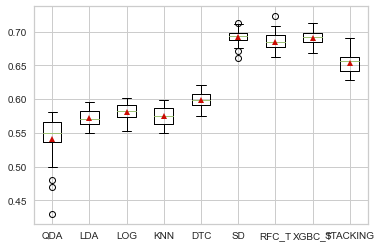

In [ ]:
# Get a list of models to evaluate
def get_models():
	models = dict()
	models['QDA'] = qda
	models['LDA'] = lda
	models['LOG'] = log
	models['KNN'] = knn_7
	models['DTC'] = dtc
	models['SD'] = soft_voting
	models['RFC_T'] = rfc_tuned
	models['XGBC_T'] = xgbc_tuned
	models['STACKING'] = get_stacking()
	return models

# Evaluate a given model using cross-validation
def evaluate_model(model, X, Y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# Get the models to evaluate
models = get_models()

# Evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, Y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# Plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

#### 8.2.3  <a class="anchor" id="8_2_3"></a> Top 7 models

In [ ]:
# Define the base models separately
level7 = list()
level7.append(('lda', lda))
level7.append(('log', log))
level7.append(('knn', knn_7))
level7.append(('dtc', dtc))
level7.append(('soft voting', soft_voting))
level7.append(('rfc tuned', rfc_tuned))
level7.append(('xgbc tuned', xgbc_tuned))
level7.append(('stacking', get_stacking()))

In [ ]:
# Get a stacking ensemble of models based on XGBC tuned
def get_stacking():
	# Define the base models
	level7 = list()
	level7.append(('lda', lda))
	level7.append(('log', log))
	level7.append(('knn', knn_7))
	level7.append(('dtc', dtc))
	level7.append(('soft voting', soft_voting))
	level7.append(('rfc tuned', rfc_tuned))
	level7.append(('xgbc tuned', xgbc_tuned))

	# Define the stacking ensemble
	model = StackingClassifier(estimators=level8, final_estimator=xgbc_tuned, cv=5)
	return model

In [ ]:
# Define the final stacking ensemble
xgbc_t_stack7 = StackingClassifier(estimators=level7, final_estimator=xgbc_tuned, cv=5)

# Fit the model on all available data
xgbc_t_stack7 = xgbc_t_stack7.fit(X, Y.values.ravel())

# Predict the response for test set
xgbc_t_stack7_y_pred = xgbc_t_stack7.predict(X_test)

[11:50:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:51:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:51:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "sca

In [ ]:
# Accuracy measures
print('Accuracy score with 7 models learnt on tuned XGBC: ' + str(round(metrics.accuracy_score(Y_test, np.round(xgbc_t_stack7_y_pred)), 3)*100)+'%')
print('Recall score with 7 models learnt on tuned XGBC:: ' + str(round(metrics.recall_score(Y_test, np.round(xgbc_t_stack7_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score with 7 models learnt on tuned XGBC:: ' + str(round(metrics.precision_score(Y_test, np.round(xgbc_t_stack7_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 7 models learnt on tuned XGBC:: ' + str(round(metrics.f1_score(Y_test, np.round(xgbc_t_stack7_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score with 7 top models: 72.6%
Recall score with 7 top models: 72.6%
Precision score with 7 top models: 72.89999999999999%
F1 with 7 top models: 72.6%


In [ ]:
# Get a stacking ensemble of models based on base XGBC
def get_stacking():
	# Define the base models
	level7 = list()
	level7.append(('log', log))
	level7.append(('knn', knn_7))
	level7.append(('dtc', dtc))
	level7.append(('xgbc tuned', xgbc_tuned))
	level7.append(('soft voting', soft_voting))
	level7.append(('rfc tuned', rfc_tuned))
	level7.append(('lda', lda))
	level7.append(('stacking', get_stacking()))

	# Define the stacking ensemble
	model = StackingClassifier(estimators=level7, final_estimator=xgbc, cv=5)
	return model

In [ ]:
# Define the stacking ensemble based on XGBC
stack7_xgbc = StackingClassifier(estimators=level7, final_estimator=xgbc, cv=5)

# Fit the model on all available data
stack7_xgbc = stack7_xgbc.fit(X, Y.values.ravel())

# Predict the response for test set
stack7_xgbc_y_pred = stack7_xgbc.predict(X_test)

In [ ]:
# Accuracy measures
print('Accuracy score with 7 models learnt on base XGBC: ' + str(round(metrics.accuracy_score(Y_test, np.round(stack7_xgbc_y_pred)), 3)*100)+'%')
print('Recall score with 7 models learnt on base XGBC: ' + str(round(metrics.recall_score(Y_test, np.round(stack7_xgbc_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score with 7 models learnt on base XGBC: ' + str(round(metrics.precision_score(Y_test, np.round(stack7_xgbc_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 7 models learnt on base XGBC: ' + str(round(metrics.f1_score(Y_test, np.round(stack7_xgbc_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score with 7 models based on XGBC: 78.8%
Recall score with 7 models based on XGBC: 78.8%
Precision score with 7 models based on XGBC: 79.3%
F1 score with 7 models based on XGBC: 78.60000000000001%


In [ ]:
# Get a stacking ensemble of models learmt on RFC tuned
def get_stacking():
	# Define the base models
	level7 = list()
	level7.append(('log', log))
	level7.append(('knn', knn_7))
	level7.append(('dtc', dtc))
	level7.append(('xgbc tuned', xgbc_tuned))
	level7.append(('soft voting', soft_voting))
	level7.append(('rfc tuned', rfc_tuned))
	level7.append(('lda', lda))
	level7.append(('stacking', get_stacking()))

	# Define the stacking ensemble
	model = StackingClassifier(estimators=level7, final_estimator=rfc_tuned, cv=5)
	return model

In [ ]:
# Define the stacking ensemble based on RFC tuned
rfc_t_stack7 = StackingClassifier(estimators=level7, final_estimator=rfc_tuned, cv=5)

# Fit the model on all available data
rfc_t_stack7 = rfc_t_stack7.fit(X, Y.values.ravel())

# Predict the response for test set
rfc_t_stack7_y_pred = rfc_t_stack7.predict(X_test)


[14:47:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:48:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:48:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "sca

In [ ]:
# Accuracy measures
print('Accuracy score with 7 models based on tuned RFC: ' + str(round(metrics.accuracy_score(Y_test, np.round(final1_y_pred)), 3)*100)+'%')
print('Recall score with 7 models based on tuned RFC:: ' + str(round(metrics.recall_score(Y_test, np.round(final1_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score with 7 models based on tuned RFC:: ' + str(round(metrics.precision_score(Y_test, np.round(final1_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 7 models based on tuned RFC:: ' + str(round(metrics.f1_score(Y_test, np.round(final1_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score with 7 models: 77.60000000000001%
Recall score with 7 models: 77.60000000000001%
Precision score with 7 models: 78.2%
F1 score with 7 models: 77.5%


#### 8.2.4  <a class="anchor" id="8_2_4"></a> Top 6 models

In [ ]:
# Define the base models separately
level6 = list()
level6.append(('log', log))
level6.append(('knn', knn_7))
level6.append(('dtc', dtc))
level6.append(('soft voting', soft_voting))
level6.append(('rfc tuned', rfc_tuned))
level6.append(('xgbc tuned', xgbc_tuned))
level6.append(('stacking', get_stacking()))

In [ ]:
def get_stacking():
	# Define the base models
	level6 = list()
	level6.append(('log', log))
	level6.append(('knn', knn_7))
	level6.append(('dtc', dtc))
	level6.append(('soft voting', soft_voting))
	level6.append(('rfc tuned', rfc_tuned))
	level6.append(('xgbc tuned', xgbc_tuned))

	# Define the stacking ensemble learnt on soft voting classifier
	model = StackingClassifier(estimators=level6, final_estimator=soft_voting, cv=5)
	return model

In [ ]:
# Define the stacking ensemble learnt on soft voting classifier
stack6_sv = StackingClassifier(estimators=level6, final_estimator=soft_voting, cv=5)

# Fit the model on all available data
stack6_sv = stack6_sv.fit(X, Y.values.ravel())

# Predict the response for test set
stack6_sv_y_pred = stack6_sv.predict(X_test)

[15:57:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:02:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:04:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "sca

In [ ]:
# Accuracy measures
print('Accuracy score with 6 models learnt on soft voting classifier: ' + str(round(metrics.accuracy_score(Y_test, np.round(stack6_sv_y_pred)), 3)*100)+'%')
print('Recall score with 6 models learnt on soft voting classifier ' + str(round(metrics.recall_score(Y_test, np.round(stack6_sv_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score with 6 models learnt on soft voting classifier: ' + str(round(metrics.precision_score(Y_test, np.round(stack6_sv_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 6 models learnt on soft voting classifier: ' + str(round(metrics.f1_score(Y_test, np.round(stack6_sv_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score with 6 models learnt on soft voting classifier: 77.0%
Recall score with 6 models learnt on soft voting classifier 77.0%
Precision score with 6 models learnt on soft voting classifier: 77.7%
F1 score with 6 models learnt on soft voting classifier: 76.9%


In [ ]:
# Get a stacking ensemble of models based on base XGBC
def get_stacking():
	# Define the base models
	level6 = list()
	level6.append(('log', log))
	level6.append(('knn', knn_7))
	level6.append(('dtc', dtc))
	level6.append(('soft voting', soft_voting))
	level6.append(('rfc tuned', rfc_tuned))
	level6.append(('xgbc tuned', xgbc_tuned))

	# Define the stacking ensemble
	model = StackingClassifier(estimators=level6, final_estimator=xgbc, cv=5)
	return model

In [ ]:
# Define the stacking ensemble based on tuned XGBC
xgbc_stack6 = StackingClassifier(estimators=level6, final_estimator=xgbc, cv=5)

# Fit the model on all available data
xgbc_stack6 = xgbc_stack6.fit(X, Y.values.ravel())

# Predict the response for test set
xgbc_stack6_y_pred = xgbc_stack6.predict(X_test)

In [ ]:
# Accuracy measures
print('Accuracy score with 6 models learnt on base XGBC: ' + str(round(metrics.accuracy_score(Y_test, np.round(xgbc_stack6_y_pred)), 3)*100)+'%')
print('Recall score with 6 models learnt on base XGBC: ' + str(round(metrics.recall_score(Y_test, np.round(xgbc_stack6_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score with 6 models learnt on base XGBC: ' + str(round(metrics.precision_score(Y_test, np.round(xgbc_stack6_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 6 models learnt on base XGBC: ' + str(round(metrics.f1_score(Y_test, np.round(xgbc_stack6_y_pred), average='weighted'), 3)*100)+'%')

In [ ]:
# Get a stacking ensemble of models based on tuned XGBC
def get_stacking():
	# Define the base models
	level6 = list()
	level6.append(('log', log))
	level6.append(('knn', knn_7))
	level6.append(('dtc', dtc))
	level6.append(('soft voting', soft_voting))
	level6.append(('rfc tuned', rfc_tuned))
	level6.append(('xgbc tuned', xgbc_tuned))

	# Define the stacking ensemble
	model = StackingClassifier(estimators=level6, final_estimator=xgbc_tuned, cv=5)
	return model

In [ ]:
# Define the stacking ensemble based on tuned XGBC
xgbc_tuned_stack6 = StackingClassifier(estimators=level6, final_estimator=xgbc_tuned, cv=5)

# Fit the model on all available data
xgbc_tuned_stack6 = xgbc_tuned_stack6.fit(X, Y.values.ravel())

# Predict the response for test set
xgbc_tuned_stack6_y_pred = xgbc_tuned_stack6.predict(X_test)

[10:15:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:15:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:15:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "sca

In [ ]:
# Accuracy measures
print('Accuracy score with 6 models learnt on tuned XGBC: ' + str(round(metrics.accuracy_score(Y_test, np.round(xgbc_tuned_stack6_y_pred)), 3)*100)+'%')
print('Recall score with 6 models learnt on tuned XGBC: ' + str(round(metrics.recall_score(Y_test, np.round(xgbc_tuned_stack6_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score with 6 models learnt on tuned XGBC: ' + str(round(metrics.precision_score(Y_test, np.round(xgbc_tuned_stack6_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 6 models learnt on tuned XGBC: ' + str(round(metrics.f1_score(Y_test, np.round(xgbc_tuned_stack6_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score of the final model: 73.4%
Recall score of the final model: 73.4%
Precision score of the final model: 73.7%
F1 of final the model: 73.4%


#### 8.2.5  <a class="anchor" id="8_2_5"></a> Top 5 models

In [239]:
# Define the base models separately
level5 = list()
level5.append(('knn', knn_7))
level5.append(('dtc', dtc))
level5.append(('soft voting', soft_voting))
level5.append(('rfc tuned', rfc_tuned))
level5.append(('xgbc tuned', xgbc_tuned))
level5.append(('stacking', get_stacking()))

In [ ]:
# Define the stacking ensemble based on tuned XGBC
def get_stacking():
	# Define the base models
	level5 = list()
	level5.append(('knn', knn_7))
	level5.append(('dtc', dtc))
	level5.append(('soft voting', soft_voting))
	level5.append(('rfc tuned', rfc_tuned))
	level5.append(('xgbc tuned', xgbc_tuned))

	# Define the stacking ensemble
	model = StackingClassifier(estimators=level5, final_estimator=xgbc_tuned, cv=5)
	return model

In [ ]:
# Define the stacking ensemble based on tuned XGBC
xgbc_t_stack5 = StackingClassifier(estimators=level5, final_estimator=xgbc_tuned, cv=5)

# Fit the model on all available data
xgbc_t_stack5 = xgbc_t_stack5.fit(X, Y.values.ravel())

# Predict the response for test set
xgbc_t_stack5_y_pred = xgbc_t_stack5.predict(X_test)

[12:55:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:56:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:56:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "sca

In [ ]:
# Accuracy measures
print('Accuracy score with 5 models learnt on tuned XGBC: ' + str(round(metrics.accuracy_score(Y_test, np.round(xgbc_t_stack5_y_pred)), 3)*100)+'%')
print('Recall score with 5 models learnt on tuned XGBC: ' + str(round(metrics.recall_score(Y_test, np.round(xgbc_t_stack5_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score with 5 models learnt on tuned XGBC: ' + str(round(metrics.precision_score(Y_test, np.round(xgbc_t_stack5_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 5 models learnt on tuned XGBC: ' + str(round(metrics.f1_score(Y_test, np.round(xgbc_t_stack5_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score with 5 models: 73.7%
Recall score with 5 models: 73.7%
Precision score with 5 models:: 73.8%
F1 score with 5 models: 73.7%


In [ ]:
def get_stacking():
	# Define the base models
	level5 = list()
	level5.append(('knn', knn_7))
	level5.append(('dtc', dtc))
	level5.append(('soft voting', soft_voting))
	level5.append(('rfc tuned', rfc_tuned))
	level5.append(('xgbc tuned', xgbc_tuned))

	# Define the stacking ensemble based on base XGBC
	model = StackingClassifier(estimators=level5, final_estimator=xgbc, cv=5)
	return model

In [ ]:
# Define the stacking ensemble based on base XGBC
xgbc_stack5 = StackingClassifier(estimators=level5, final_estimator=xgbc, cv=5)

# Fit the model on all available data
xgbc_stack5 = xgbc_stack5.fit(X, Y.values.ravel())

# Predict the response for test set
xgbc_stack5_y_pred = xgbc_stack5.predict(X_test)

[11:13:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:16:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:17:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metric", "sca

In [ ]:
# Accuracy measures
print('Accuracy score with 5 models learnt on base XGBC: ' + str(round(metrics.accuracy_score(Y_test, np.round(xgbc_stack5_y_pred)), 3)*100)+'%')
print('Recall score with 5 models learnt on base XGBC: ' + str(round(metrics.recall_score(Y_test, np.round(xgbc_stack5_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score with 5 models learnt on base XGBC: ' + str(round(metrics.precision_score(Y_test, np.round(xgbc_stack5_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 5 models learnt on base XGBC: ' + str(round(metrics.f1_score(Y_test, np.round(xgbc_stack5_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score with 5 models learnt on base XGBC: 79.9%
Recall score with 5 models learnt on base XGBC: 79.9%
Precision score with 5 models learnt on base XGBC: 80.30000000000001%
F1 score with 5 models learnt on base XGBC: 79.80000000000001%


In [240]:
def get_stacking():
	# Define the base models
	level5 = list()
	level5.append(('knn', knn_7))
	level5.append(('dtc', dtc))
	level5.append(('soft voting', soft_voting))
	level5.append(('rfc tuned', rfc_tuned))
	level5.append(('xgbc tuned', xgbc_tuned))

	# Define the stacking ensemble based on tuned random forest classifier
	model = StackingClassifier(estimators=level5, final_estimator=rfc_tuned, cv=5)
	return model

In [241]:
# Define the stacking ensemble based on tuned random forest classifier
stack5_rfc_t = StackingClassifier(estimators=level5, final_estimator=rfc_tuned, cv=5)

# Fit the model on all available data
stack5_rfc_t = stack5_rfc_t.fit(X, Y.values.ravel())

# Predict the response for test set
stack5_rfc_t_y_pred = stack5_rfc_t.predict(X_test)

In [ ]:
# Accuracy measures
print('Accuracy score with 5 models learnt on tuned RFC: ' + str(round(metrics.accuracy_score(Y_test, np.round(stack5_rfc_t_y_pred)), 3)*100)+'%')
print('Recall score with 5 models learnt on tuned RFC: ' + str(round(metrics.recall_score(Y_test, np.round(stack5_rfc_t_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score with 5 models learnt on tuned RFC: ' + str(round(metrics.precision_score(Y_test, np.round(stack5_rfc_t_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 5 models learnt on tuned RFC: ' + str(round(metrics.f1_score(Y_test, np.round(stack5_rfc_t_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score with 5 models learnt on tuned RFC: 82.1%
Recall score with 5 models learnt on tuned RFC: 82.1%
Precision score with 5 models learnt on tuned RFC: 82.39999999999999%
F1 score with 5 models learnt on tuned RFC: 82.1%


In [242]:
# Accuracy measures
print('Accuracy score with 5 models learnt on tuned RFC: ' + str(round(metrics.accuracy_score(Y_test, np.round(stack5_rfc_t_y_pred)), 3)*100)+'%')
print('Recall score with 5 models learnt on tuned RFC: ' + str(round(metrics.recall_score(Y_test, np.round(stack5_rfc_t_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score with 5 models learnt on tuned RFC: ' + str(round(metrics.precision_score(Y_test, np.round(stack5_rfc_t_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 5 models learnt on tuned RFC: ' + str(round(metrics.f1_score(Y_test, np.round(stack5_rfc_t_y_pred), average='weighted'), 3)*100)+'%')

Accuracy score with 5 models learnt on tuned RFC: 78.5%
Recall score with 5 models learnt on tuned RFC: 78.5%
Precision score with 5 models learnt on tuned RFC: 79.2%
F1 score with 5 models learnt on tuned RFC: 78.4%


In [ ]:
final_cv = cross_val_score(stack5_rfc_t, X_train, Y_train.values.ravel(), cv=5, scoring='accuracy')
print('Final cross validation score of the best model is ' + str(round(final_cv[1],3)*100) + '%')

#### 8.2.6  <a class="anchor" id="8_2_6"></a> Top 4 models

In [ ]:
def get_stacking():
	# Define the base models
	level4 = list()
	level4.append(('dtc', dtc))
	level4.append(('soft voting', soft_voting))
	level4.append(('rfc tuned', rfc_tuned))
	level4.append(('xgbc tuned', xgbc_tuned))

	# Define the final stacking ensemble learnt on base Gaussian classifier
	model = StackingClassifier(estimators=level4, final_estimator=xgbc, cv=5)
	return model

In [ ]:
# Define the base models separately
level4 = list()
level4.append(('dtc', dtc))
level4.append(('soft voting', soft_voting))
level4.append(('rfc tuned', rfc_tuned))
level4.append(('xgbc tuned', xgbc_tuned))
level4.append(('stacking', get_stacking()))

In [ ]:
# Define the final stacking ensemble learnt on base Gaussian classifier
stack4_xgbc = StackingClassifier(estimators=level4, final_estimator=xgbc, cv=5)

# Fit the model on all available data
stack4_xgbc = stack4_xgbc.fit(X, Y.values.ravel())

# Predict the response for test set
stack4_xgbc_y_pred = stack4_xgbc.predict(X_test)

In [ ]:
# Accuracy measures
print('Accuracy score with 4 models learnt on base XGBC: ' + str(round(metrics.accuracy_score(Y_test, np.round(stack4_xgbc_y_pred)), 3)*100)+'%')
print('Recall score with 4 models learnt on base XGBC: ' + str(round(metrics.recall_score(Y_test, np.round(stack4_xgbc_y_pred), average='weighted'), 3)*100)+'%')
print('Precision score with 4 models learnt on base XGBC: ' + str(round(metrics.precision_score(Y_test, np.round(stack4_xgbc_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('F1 score with 4 models learnt on base XGBC: ' + str(round(metrics.f1_score(Y_test, np.round(stack4_xgbc_y_pred), average='weighted'), 3)*100)+'%')

## Part 9: <a class="anchor" id="part9"></a> Evaluation of the final model

### 9.1  <a class="anchor" id="9_1"></a> Confusion matrix

In [ ]:
# URL: https://pythonawesome.com/multi-class-confusion-matrix-library-in-python/#:~:text=PyCM%20is%20a%20multi-class%20confusion%20matrix%20library%20written,that%20supports%20most%20classes%20and%20overall%20statistics%20parameters.

y_actu = Y_test['Profit_Class'].to_numpy()
y_pred = stack5_rfc_t_y_pred
cm = ConfusionMatrix(actual_vector=y_actu, predict_vector=y_pred)
cm.classes
print(cm)

Predict   0         1         2         
Actual
0         89        39        12        

1         7         682       134       

2         2         150       812       





Overall Statistics : 

95% CI                                                            (0.80439,0.83858)
ACC Macro                                                         0.88099
ARI                                                               0.47495
AUNP                                                              0.83608
AUNU                                                              0.82981
Bangdiwala B                                                      0.68461
Bennett S                                                         0.73223
CBA                                                               0.75368
CSI                                                               0.61516
Chi-Squared                                                       1934.54043
Chi-Squared DF                                

* AUC of class 0 is 0.83 which is very good.
* AUC of class 1 is 0.83 which is very good.
* AUC of class 2 is 0.85 which is very good.
<br />
<br />
* F1 of class 0 is 0.75 which is good.
* F1 of class 1 is 0.81 which is very good.
* F1 of class 2 is 0.85 which is very good.
<br />
<br />
Class 0 - low recoverability/unrecoverable projects
Class 1 - average recoverability
Class 2 - highly recoverable projects

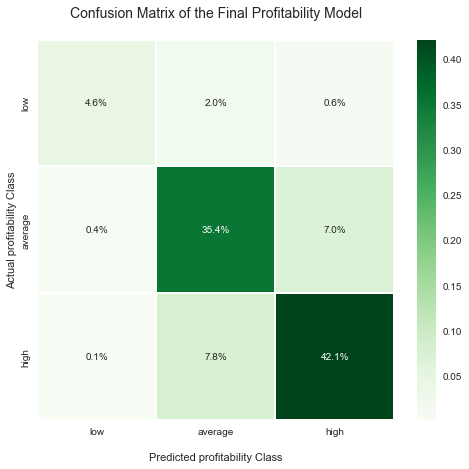

In [207]:
#URL: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#:~:text=You%20can%20create%20the%20confusion%20matrix%20using%20the,Positives%2C%20False%20Negatives%2C%20and%20True%20negatives.%20%2A%2A%20Snippet%2A%2A

plt.subplots(figsize = (8,7))
final_matrix = confusion_matrix(Y_test, stack5_rfc_t_y_pred)
ax = sns.heatmap(final_matrix/np.sum(final_matrix), annot=True, fmt='.1%', linewidths=.2, cmap='Greens')

ax.set_title('Confusion Matrix of the Final Profitability Model\n', fontsize = 14);
ax.set_xlabel('\nPredicted profitability Class')
ax.set_ylabel('Actual profitability Class');
ax.xaxis.set_ticklabels(['low','average', 'high'])
ax.yaxis.set_ticklabels(['low','average', 'high'])
plt.savefig('figures/profit/Confusion Matrix of the Final Profitability Model')

### 9.2  <a class="anchor" id="9_2"></a> Cost matrix

In [208]:
# URL: https://imbalanced-ensemble.readthedocs.io/en/latest/auto_examples/classification/plot_cost_matrix.html

init_kwargs = {
    'n_estimators': 5,
    'random_state': 1,
}
adacost_clf = imbens.ensemble.AdaCostClassifier(**init_kwargs)

cost_matrices = {}

def plot_cost_matrix(cost_matrix, title:str, **kwargs):
    ax = sns.heatmap(data=cost_matrix, **kwargs)
    ax.set_ylabel('Predicted class')
    ax.set_xlabel('Ground truth')
    ax.set_title(title)

adacost_clf.fit(X_train, Y_train.values.ravel())

AdaCostClassifier(n_estimators=5, random_state=1)

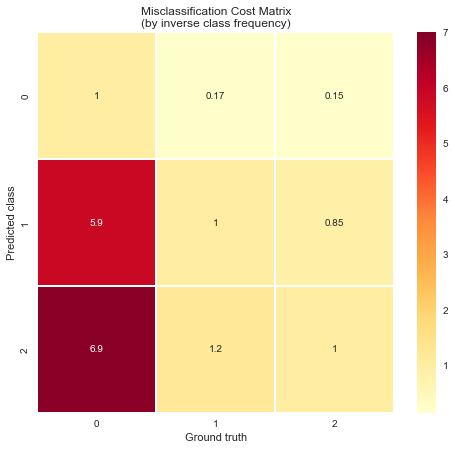

In [210]:
# Default cost matrix
plt.subplots(figsize = (8,7))
title = 'Misclassification Cost Matrix\n(by inverse class frequency)'
cost_matrices[title] = adacost_clf.cost_matrix_
plot_cost_matrix(adacost_clf.cost_matrix_, title, annot=True, cmap='YlOrRd', vmax=7, linewidths=.2)
plt.savefig('figures/profit/Misclassification Cost Matrix')

In this cost matrix:
* correct classification of highly profitable projects gives a +1 benefit,
* misclassification of a highly recoverable project as average project has nearly the same impact 0f 0.94 units,
* whilst mistaking a highly recoverable project for an unrecoverable one is neutral (+0.059);
<br />
<br />
* correct classification of average projects gives a +1 benefit,
* misclassification of an average project as highly profitable project has nearly the same impact of +1.2 units,
* mistaking an average project for an unprofitable one is also neutral (+0.17);
<br />
<br />
* correct classification of unprofitable projects gives a +1 benefit,
* misclassification of an unprofitable project for an average one brings 5.9 units of impact,
* mistaking an unprofitable project for highly profitable has the most drastic impact on prediction cost with 6.9 units of impact.


### 9.3  <a class="anchor" id="9_3"></a> Receiver Operating Characteristic (ROC) curve

In [243]:
#URL: https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification

# Binarize the output
Y = label_binarize(Y, classes=[0, 1, 2])
n_classes = Y.shape[1]

# Learn to predict each class against the other
FINAL_MODEL = stack5_rfc_t
OVRC = OneVsRestClassifier(FINAL_MODEL)
OVRC.fit(X_train, Y_train)

# Shuffle and split training and test sets
X_train, X_test, Y_train, Y_test =\
    train_test_split(X, Y, test_size=0.2, random_state=1)

# Classifier
Y_score = OVRC.fit(X_train, Y_train).predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true Positive Rate')
    plt.title('ROC curve class {}'.format(i))
    plt.legend(loc='lower right')
    plt.show()
    plt.savefig('figures/profit/ROC curve for each profitability class')

c:\Users\MarfaPopova\S2R Analytics\Development & Support Team - Power BI for Synergy - Advanced Analytics\DataFlowExtract\venv\lib\site-packages\sklearn\ensemble\_voting.py:384: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([clf.predict_proba(X) for clf in self.estimators_])


ValueError: could not broadcast input array from shape (1541,3) into shape (1541,)

In [ ]:
#URL: https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier

fpr = dict()
tpr = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i],
                                  Y_score[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='best')
plt.title('ROC curve for all classes')
plt.show()
plt.savefig('figures/profit/ROC curve for all profitability classes')

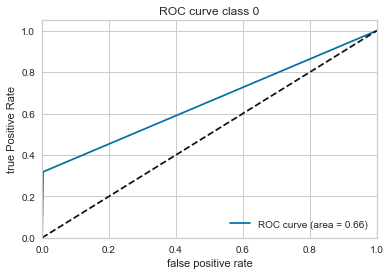

<Figure size 432x288 with 0 Axes>

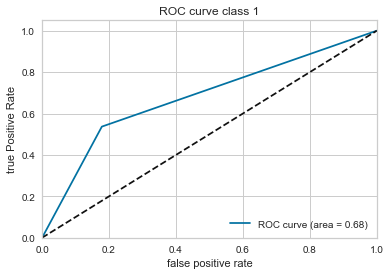

<Figure size 432x288 with 0 Axes>

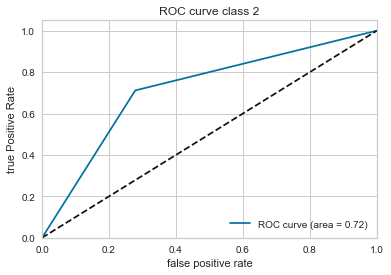

<Figure size 432x288 with 0 Axes>

In [ ]:
#URL: https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification

# Binarize the output
Y = label_binarize(Y, classes=[0, 1, 2])
n_classes = Y.shape[1]

# Learn to predict each class against the other
FINAL_MODEL = rfc_tuned
OVRC = OneVsRestClassifier(FINAL_MODEL)
OVRC.fit(X_train, Y_train)

# Shuffle and split training and test sets
X_train, X_test, Y_train, Y_test =\
    train_test_split(X, Y, test_size=0.2, random_state=1)

# Classifier
Y_score = OVRC.fit(X_train, Y_train).predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true Positive Rate')
    plt.title('ROC curve class {}'.format(i))
    plt.legend(loc='lower right')
    plt.show()
    plt.savefig('figures/profit/ROC curve for each profitability class')

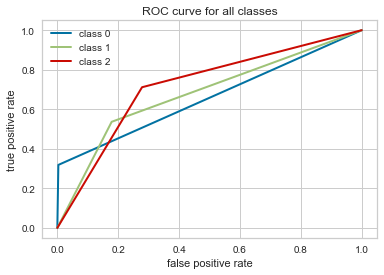

In [ ]:
#URL: https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier

fpr = dict()
tpr = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i],
                                  Y_score[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='best')
plt.title('ROC curve for all classes')
plt.show()
plt.savefig('figures/profit/ROC curve for all profitability classes')

### 9.4  <a class="anchor" id="9_4"></a> Precision-recall curve

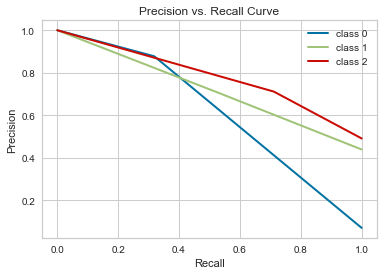

<Figure size 432x288 with 0 Axes>

In [ ]:
#URL: https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier

# Binarize the output
Y = label_binarize(Y, classes=[0, 1, 2])
n_classes = Y.shape[1]

# Shuffle and split training and test sets
X_train, X_test, Y_train, Y_test =\
    train_test_split(X, Y, test_size=0.2, random_state=1)

precision = dict()
recall = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        Y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.title('Precision vs. Recall Curve')
plt.show()
plt.savefig('figures/profit/Precision-recall curve for all profitability classes')

### 9.5  <a class="anchor" id="9_5"></a> Feature importance

In [ ]:
rfc_tuned.feature_names = X.columns
final_feature_importance = pd.DataFrame({'Feature': rfc_tuned.feature_names,'Importance':rfc_tuned.feature_importances_})
final_feature_importance = final_feature_importance.sort_values(by = ['Importance'], ascending = False)

c:\Users\MarfaPopova\S2R Analytics\Development & Support Team - Power BI for Synergy - Advanced Analytics\DataFlowExtract\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


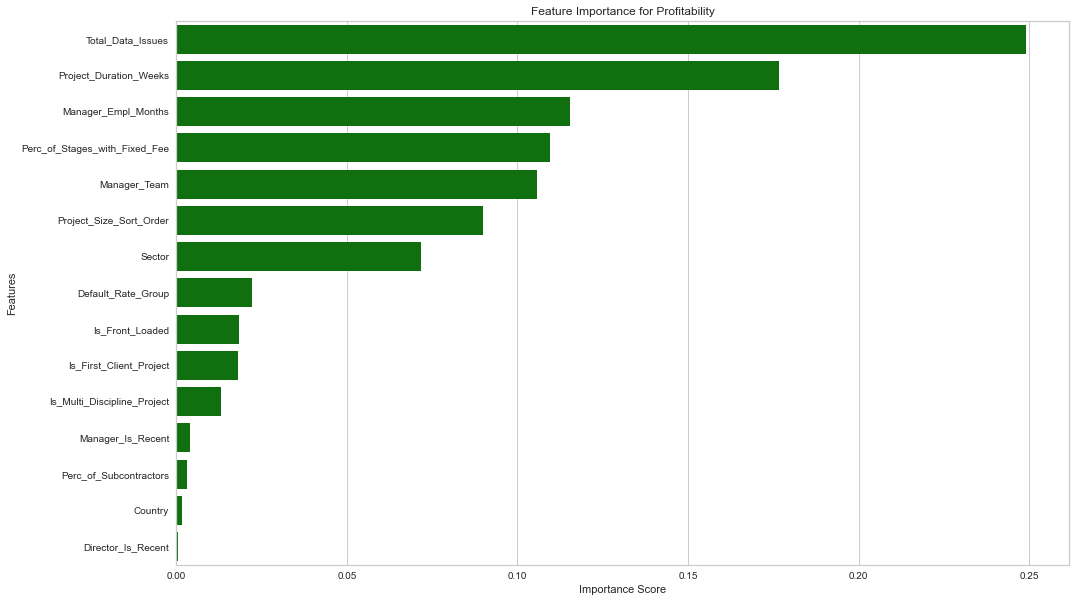

In [ ]:
# Plotting a bar plot for feature importance
fig, ax = plt.subplots(figsize = (16,10))
sns.barplot(final_feature_importance['Importance'], final_feature_importance['Feature'], color = 'green')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.xticks(rotation = 'horizontal')
plt.title('Feature Importance for Profitability')
plt.savefig('figures/profit/Final Feature Importance')